In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset


In [3]:
df = pd.read_csv('feature_data.csv')

# ResNet18

In [4]:
df["filepath"] = "data/" + df["filename"]  # Prepend 'data/' to filename

# Split dataset into train & test (80-20 split)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

# Print dataset sizes
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")


Train size: 160, Test size: 40


In [5]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row["filepath"]
        label = row["label"]

        # Load image using OpenCV
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = cv2.resize(image, (224, 224))  # Resize for ResNet

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# Define image transformations (ResNet expects normalization)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create train & test datasets
train_dataset = ImageDataset(train_df, transform=transform)
test_dataset = ImageDataset(test_df, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [6]:
# Load pretrained ResNet
resnet = models.resnet18(pretrained=True)

# Modify last layer for binary classification
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 1),  # Single output neuron
    nn.Sigmoid()  # Binary classification (0 or 1)
)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)


d:\AlemenoQR\qrcode\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\AlemenoQR\qrcode\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(resnet.parameters(), lr=0.001)


In [8]:
num_epochs = 10

for epoch in range(num_epochs):
    resnet.train()  # Set model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.unsqueeze(1)  # Reshape for BCE Loss

        optimizer.zero_grad()
        outputs = resnet(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

print("Training complete.")


Epoch [1/10], Loss: 0.2167
Epoch [2/10], Loss: 0.1980
Epoch [3/10], Loss: 0.0345
Epoch [4/10], Loss: 0.0038
Epoch [5/10], Loss: 0.0068
Epoch [6/10], Loss: 0.0064
Epoch [7/10], Loss: 0.0009
Epoch [8/10], Loss: 0.0015
Epoch [9/10], Loss: 0.0008
Epoch [10/10], Loss: 0.0017
Training complete.


In [9]:
resnet.eval()  # Set model to evaluation mode
misclassified = []  # Store misclassified images

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.unsqueeze(1)

        outputs = resnet(images)  # Forward pass
        preds = (outputs > 0.5).int()  # Convert probabilities to 0/1

        for i in range(len(labels)):
            if preds[i] != labels[i]:  # Misclassified image
                misclassified.append((images[i].cpu(), labels[i].item(), preds[i].item()))

# Print number of misclassified images
print(f"Total misclassified images: {len(misclassified)}")


Total misclassified images: 0


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Lists to store true labels and predictions
true_labels = []
predictions = []

# Evaluate model
resnet.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.unsqueeze(1)

        outputs = resnet(images)  # Forward pass
        preds = (outputs > 0.5).int()  # Convert probabilities to binary 0/1

        true_labels.extend(labels.cpu().numpy())  # Store true labels
        predictions.extend(preds.cpu().numpy())  # Store predictions

# Convert lists to numpy arrays
y_true = np.array(true_labels).flatten()
y_pred = np.array(predictions).flatten()


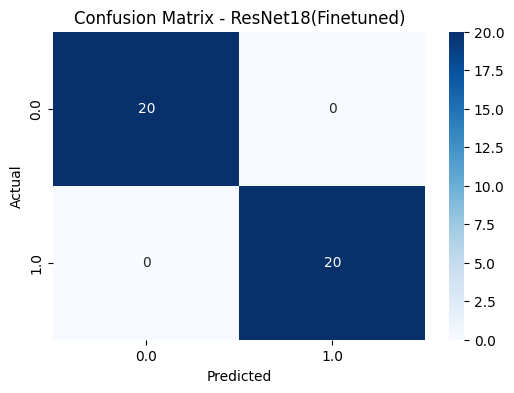

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [11]:
# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)


# 🔹 Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - ResNet18(Finetuned)")
plt.show()

# 🔹 Print Classification Report
print(classification_report(y_true, y_pred))